# ***Installing Essential Packages***

In [1]:
!pip install sentinelhub
!pip install gdal
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.4/245.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.3 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6084 sha256=1c52c8a18c241582b7bf196e91b4ea6b9b99986461ede9a98c375e69febbebf4
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 27.0 MB/s eta 0:00:00


# ***Importing Libraries and functions***

In [2]:

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    Geometry,
    to_utm_bbox
)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
#from osgeo import gdal
from rasterio.plot import show
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from PIL import Image

# ***Downloading Sentinel-2 Data***

In [3]:
CLIENT_ID = ''
CLIENT_SECRET = ''

In [4]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET
if not config.sh_client_id or not config.sh_client_secret:
  print('Please provide credentials to use Process API.')

In [5]:
coords = (-80.68715353939942, 43.5306092687972, -80.31361838314942, 43.73139417849985)

resolution = 20

bbox = BBox(bbox=coords, crs=CRS.WGS84)
image_size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {image_size}')

Image shape at 20 m resolution: (1500, 1124)


In [6]:
def Data_access(start_date=None, end_date=None, year=None, mask_crs=None, list1=None):
    evalscript = """//VERSION=3

    function setup() {
      return {
        input: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"],
        output:{bands: 12}
      };
    }
    function evaluatePixel(sample) {
        return [2.5*sample.B04,2.5*sample.B03,2.5*sample.B02,2.5*sample.B01,2.5*sample.B08,2.5*sample.B12,2.5*sample.B11,2.5*sample.B09,2.5*sample.B8A,2.5*sample.B07,2.5*sample.B06,2.5*sample.B05];
      }


    """

    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(start_date, end_date),

                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),
        ],
        bbox=bbox,

        geometry = Geometry(geometry={"type":"Polygon","coordinates":[[[-80.68715353939942,43.5306092687972],[-80.31361838314942,43.5306092687972],[-80.31361838314942,43.73139417849985],[-80.68715353939942,43.73139417849985],[-80.68715353939942,43.5306092687972]]]}, crs=CRS.WGS84),

        size=image_size,
        config=config,
        data_folder='/content/data/'+str(year)
    )

    response = request.get_data(save_data=True)
    os.listdir('/content/data/'+str(year))
    for file_name in os.listdir('/content/data/'+str(year)):
        if file_name not in list1:
            list1.append(file_name)
    #print(list1)
    return list1

## Downloading by defined Time-stamps

In [7]:
dates = [["-05-01","-05-31"],["-06-01","-06-30"],["-07-01","-07-31"],["-08-01","-08-31"],["-09-01","-09-30"],["-10-01","-10-31"]]
years = [2018, 2019, 2020, 2021]
com_lis = {}
for year in years:
  lis = []
  for date in dates:
    start_date = str(year)+date[0]
    end_date = str(year)+date[1]
    lis = Data_access(start_date=start_date, end_date=end_date, year=year, list1=lis)

  com_lis[year]=lis


In [8]:
com_lis

{2018: ['12a39abe0eebb9a28294579b7acc9901',
  'f25dfe3267f3a9b005b77b9bcd9d6323',
  '12e1c9f5017a9033ddb8716e95d6e035',
  'fd437c9e1f432f47fe9725e39d043206',
  '77a278b4b8f005e233fc5550c9afc719',
  'd98f402c5e8fbc6369f7e26ce496d63e'],
 2019: ['b49282fbcb91ac9fb3ec61eeac0ed670',
  'c6c858c2c9e8008d8cec763ddaa98c47',
  'e61e2e95cef887a9d60f04071280f2b8',
  'ed70e853d716c0eeab683cbbfb80109c',
  '319b33e21247ff61bfc6b9e80979cf6b',
  'dd3eee2c96249991e6ab981bd302fb23'],
 2020: ['2a101e9949bdf44cdff65ab58f535432',
  '3cdd6171ebf549f9a584b41982d2bdf9',
  '75c084ffd5d755416ad6316afb16a903',
  'bfb2a434f468bd129e8ada9fe60f69cc',
  '49ca9432c18479fd5c11c8b8f44c1de1',
  '53c37e9558f14cfecb250565af4f22f4'],
 2021: ['646b1363378a0f364e8258a03dd166e6',
  '4c90de9861a96cfa81350f73a808312f',
  '8c58e5894feaf2cb3bc156cf401d970d',
  '4eceb98c7266d01e852f092b25aa2103',
  'd3f532c2cdc8bf54657d7ec2adb011b5',
  '6a81cba9493d17eeaa184fa21567e215']}

In [9]:
!mkdir /content/ground_data

In [10]:
from natsort import natsorted
path1 = []
path2 = []
path3 = []
path4 = []
for a in com_lis.keys():
  if a == 2018:
    for b in com_lis[a]:
      path1.append("/content/data/2018/" + str(b) +"/response.tiff")
  if a == 2019:
    for b in com_lis[a]:
      path2.append("/content/data/2019/" + str(b) +"/response.tiff")
  if a == 2020:
    for b in com_lis[a]:
      path3.append("/content/data/2020/" + str(b) +"/response.tiff")
  if a == 2021:
    for b in com_lis[a]:
      path4.append("/content/data/2021/" + str(b) +"/response.tiff")

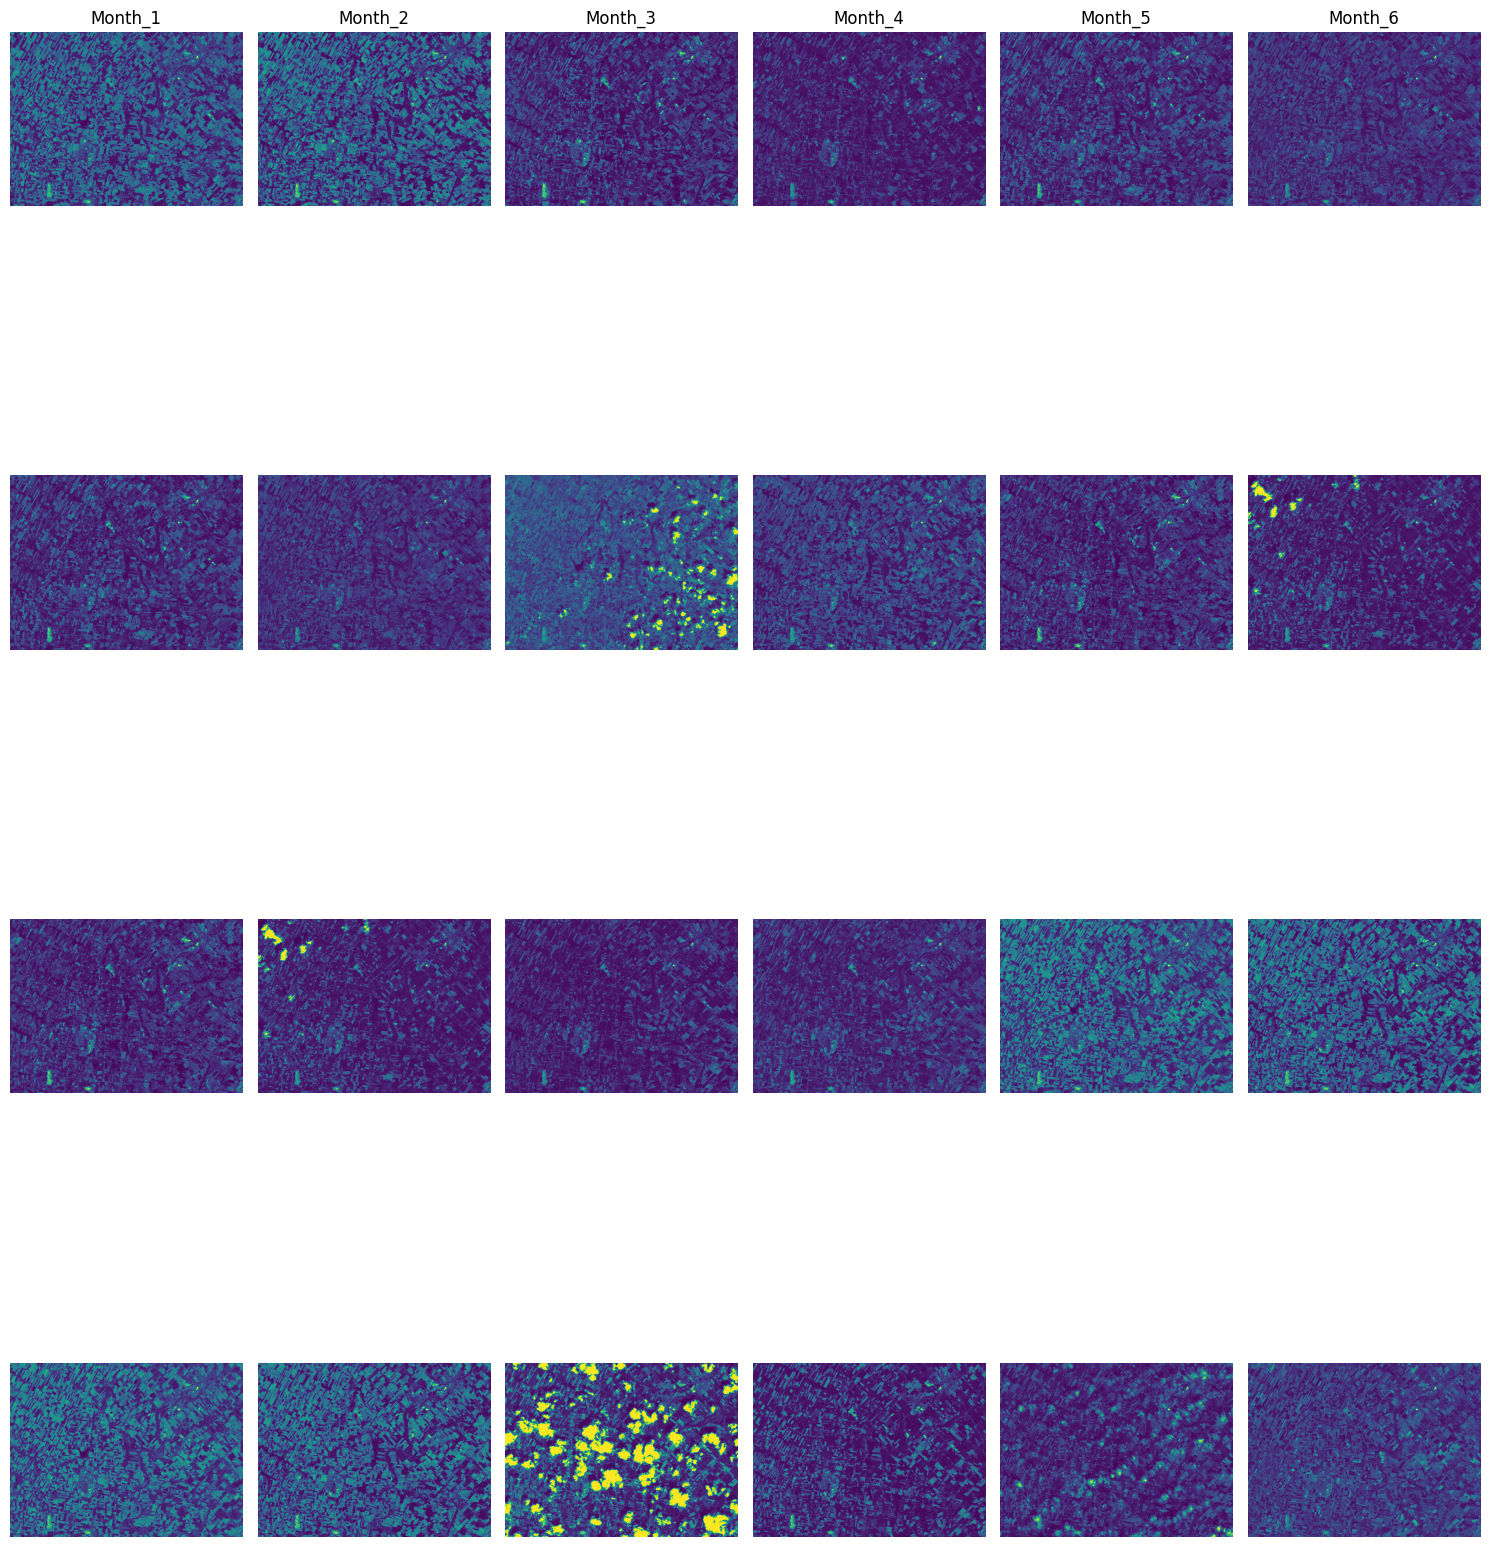

In [11]:
import matplotlib.pyplot as plt
from tifffile.tifffile import imread

all_paths = path1 + path2 + path3 + path4
fig, axs = plt.subplots(4, 6, figsize=(15, 20))
for i in range(6):
    axs[0, i].set_title('Month_' + str(i+1))
for i in range(4):
    for j in range(6):
        index = 4*i + j
        img = imread(all_paths[index])
        axs[i, j].imshow(img[:,:,0])
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()


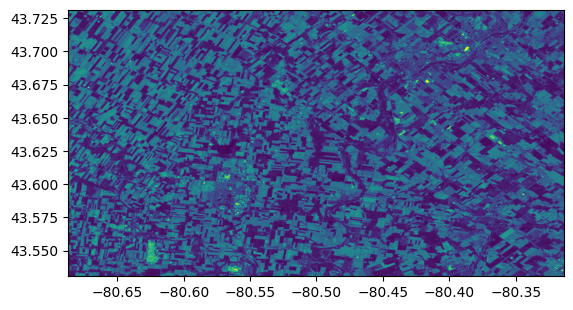

<Axes: >

In [12]:
img = rasterio.open(path1[0])
show(img)


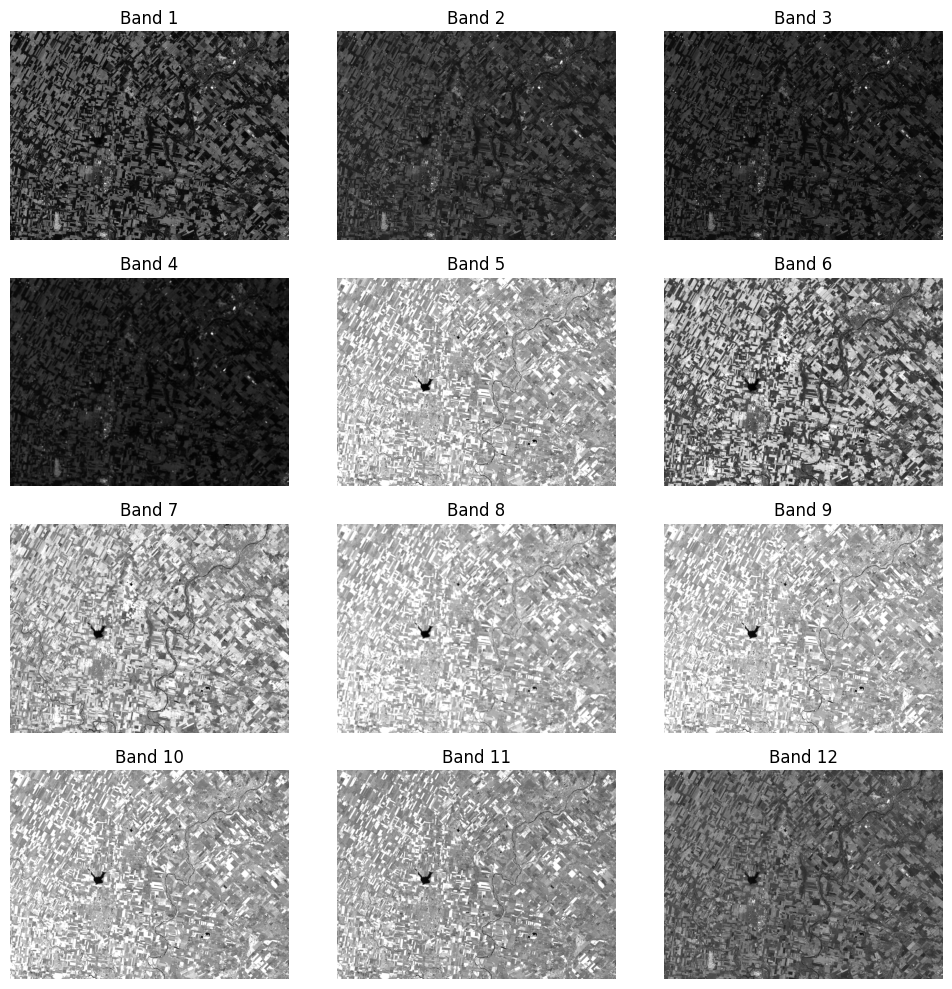

In [13]:
num_bands = img.count

num_rows = 4
num_cols = 3


fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Loop through each band and plot it in a subplot
for band in range(1, num_bands + 1):

    row_index = (band - 1) // num_cols
    col_index = (band - 1) % num_cols

    band_data = img.read(band)

    # Plot the band in the corresponding subplot
    axes[row_index, col_index].imshow(band_data, cmap='gray')
    axes[row_index, col_index].set_title(f'Band {band}')
    axes[row_index, col_index].axis('off')

plt.tight_layout()
plt.show()

# ***Preprocessing***

## Corping & Aligning Mask Using Pillow

In [ ]:
# Pillow cropping and Resizing

def align_and_crop(image_path, mask_path, cropped_path):
    # Load the 12-band image
    with rasterio.open(image_path) as src:
        profile = src.profile

    # Load the mask image
    with rasterio.open(mask_path) as src_mask:
        profile_mask = src_mask.profile
        data_mask = src_mask.read()

    # Get the transformation parameters to align the mask with the 12-band image
    transform, width, height = calculate_default_transform(
        src_mask.crs, src.crs, src_mask.width, src_mask.height, *src_mask.bounds
    )

    # Update the profile of the mask image
    profile_mask.update({
        'crs': src.crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create an empty numpy array for the aligned mask
    aligned_mask = np.empty((height, width))

    # Reproject the data to the new array
    reproject(
        source=data_mask,
        destination=aligned_mask,
        src_transform=src_mask.transform,
        src_crs=src_mask.crs,
        dst_transform=transform,
        dst_crs=src.crs,
        resampling=Resampling.nearest
    )

    # Convert the numpy array to a PIL image
    img = Image.fromarray(aligned_mask)

    # Get the bounding box of the non-empty region
    bbox = img.getbbox()

    # Crop the image using the bounding box
    cropped_img = img.crop(bbox)

    # Resize the cropped image to the size of the input image
    resized_img = cropped_img.resize((src.width, src.height))

    # Save the resized image
    resized_img.save(cropped_path)


image_paths = [path1, path2, path3, path4]

for a, b in enumerate(os.listdir('/content/ground_data')):
  image_path = image_paths[a][0]
  mask_path =   os.path.join('/content/ground_data', b)
  out_dir = "/content/aligned_mask"
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)

  cropped_path = os.path.join(out_dir, 'ground_'+str(years[a])+'.tif')  # Replace with your cropped file path

  align_and_crop(image_path, mask_path, cropped_path)


## Corping & Aligning Mask using Open-CV & Rasterio

In [15]:
# Cv2 resizing and rasterio saving

import cv2
def align_and_crop(image_path, mask_path, cropped_path):

    with rasterio.open(image_path) as src:
        profile = src.profile

    with rasterio.open(mask_path) as src_mask:
        profile_mask = src_mask.profile
        data_mask = src_mask.read()


    transform, width, height = calculate_default_transform(
        src_mask.crs, src.crs, src_mask.width, src_mask.height, *src_mask.bounds
    )

    profile_mask.update({
    'crs': src.crs,
    'transform': transform,
    'width': width,
    'height': height,
    'count': 1
    })

    aligned_mask = np.empty((height, width))

    reproject(
        source=data_mask,
        destination=aligned_mask,
        src_transform=src_mask.transform,
        src_crs=src_mask.crs,
        dst_transform=transform,
        dst_crs=src.crs,
        resampling=Resampling.nearest
    )

    img = aligned_mask.astype(np.uint8)

    y, x = np.where(img != 0)
    bbox = [np.min(x), np.min(y), np.max(x), np.max(y)]

    cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]

    #resized_img = cv2.resize(cropped_img, (src.width, src.height), interpolation = cv2.INTER_AREA)

    with rasterio.open(cropped_path, 'w', **profile) as dst:
      dst.write(cropped_img, 1)

image_paths = [path1, path2, path3, path4]
for a, b in enumerate(os.listdir('/content/ground_data')):
  image_path = image_paths[a][0]
  mask_path =   os.path.join('/content/ground_data', b)
  out_dir = "/content/aligned_mask"
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)
  cropped_path = os.path.join(out_dir, 'ground_'+str(years[a])+'.tif')  # Replace with your cropped file path
  align_and_crop(image_path, mask_path, cropped_path)

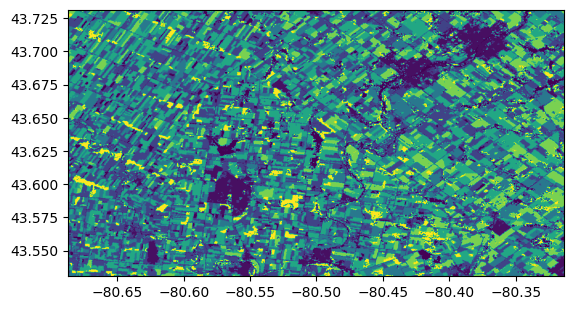

((1124, 1500), (1124, 1500))

In [17]:
im = rasterio.open('/content/aligned_mask/ground_2018.tif')
show(im)
img.shape, im.shape

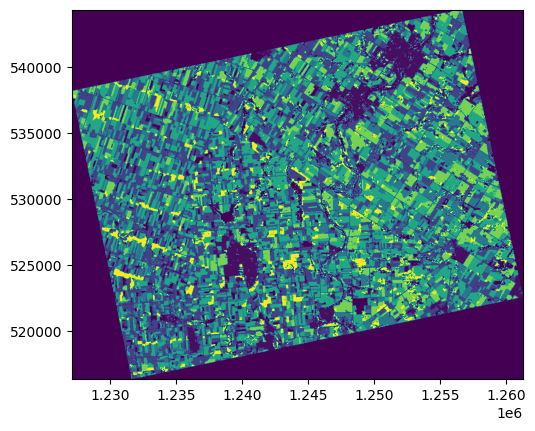

((1124, 1500), (933, 1137))

In [18]:
# Original Ground
al_c = rasterio.open('/content/ground_data/2018.tif')
show(al_c)
img.shape, al_c.shape

## ***Removing Redundant bands from mask***

Resampling of mask adds extra bands with zero values to mask so we only take first band that has the actuall mask by extracting 1st band from the mask image

In [20]:
for i in os.listdir('/content/aligned_mask'):
  with rasterio.open(os.path.join('/content/aligned_mask', i)) as src:
        profile = src.profile
        img1 = src.read(1)

  out_img = os.path.join('/content/aligned_mask', i)

  # update the metadata
  profile.update({
    'crs': src.crs,
    'count': 1
    })
  # save the band1 as a tif file
  with rasterio.open(out_img, "w", **profile) as dest:
      dest.write(img1, 1) # write band1 to the first band


In [21]:
am = imread('/content/aligned_mask/ground_2018.tif')
am.shape, np.unique(am)

((1124, 1500), array([  0,  10,  50, 100, 150, 200, 250], dtype=uint8))

## ***Stack Images***

In [22]:
from tifffile.tifffile import imread, imwrite

def stack_tiff_files(input_paths, output_path):
    # Initialize a list to hold the image data
    images = []

    # Loop over the input paths
    for path in input_paths:
        # Read each image and append to the list
        img = imread(path)
        images.append(img)

    # Stack images along a new first axis
    stacked_img = np.stack(images, axis=0)

    # Write the stacked image to the output path
    imwrite(output_path, stacked_img)

if not os.path.exists('/content/stacked'):
  os.makedirs('/content/stacked')
stacks = []
for i, path in enumerate(image_paths):
  out_path = os.path.join('/content/stacked', 'stack_'+str(years[i])+'.tiff')
  stacks.append(out_path)
  print(f"Out_path: {out_path} \nIn path: {path}")
  # Stack TIFF files for each year
  stack_tiff_files(path, out_path)


Out_path: /content/stacked/stack_2018.tiff 
In path: ['/content/data/2018/12a39abe0eebb9a28294579b7acc9901/response.tiff', '/content/data/2018/f25dfe3267f3a9b005b77b9bcd9d6323/response.tiff', '/content/data/2018/12e1c9f5017a9033ddb8716e95d6e035/response.tiff', '/content/data/2018/fd437c9e1f432f47fe9725e39d043206/response.tiff', '/content/data/2018/77a278b4b8f005e233fc5550c9afc719/response.tiff', '/content/data/2018/d98f402c5e8fbc6369f7e26ce496d63e/response.tiff']
Out_path: /content/stacked/stack_2019.tiff 
In path: ['/content/data/2019/b49282fbcb91ac9fb3ec61eeac0ed670/response.tiff', '/content/data/2019/c6c858c2c9e8008d8cec763ddaa98c47/response.tiff', '/content/data/2019/e61e2e95cef887a9d60f04071280f2b8/response.tiff', '/content/data/2019/ed70e853d716c0eeab683cbbfb80109c/response.tiff', '/content/data/2019/319b33e21247ff61bfc6b9e80979cf6b/response.tiff', '/content/data/2019/dd3eee2c96249991e6ab981bd302fb23/response.tiff']
Out_path: /content/stacked/stack_2020.tiff 
In path: ['/content/

In [23]:
stacks

['/content/stacked/stack_2018.tiff',
 '/content/stacked/stack_2019.tiff',
 '/content/stacked/stack_2020.tiff',
 '/content/stacked/stack_2021.tiff']

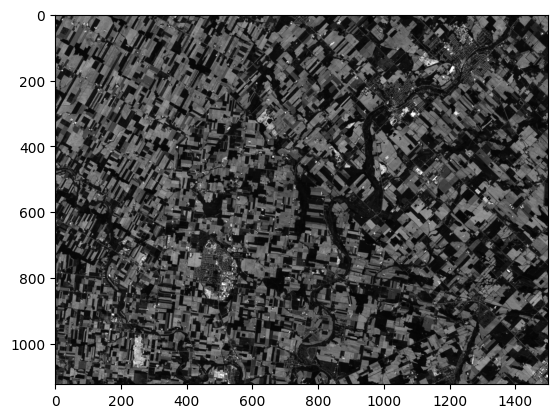

In [24]:

sta =imread('/content/stacked/stack_2020.tiff')

plt.imshow(sta[1,:,:,0], cmap='gray')

In [25]:
sta.shape

(6, 1124, 1500, 12)

## ***Creating Patches***

In [26]:
!pip install patchify

In [27]:
from patchify import patchify, unpatchify
from scipy import stats
from tifffile.tifffile import imread
from skimage.util import view_as_windows

for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                single_patch_img = patches[i,j,:,:]
                #single_patch_img = single_patch_img[0]
                patches_list.append(single_patch_img)
        patch_data = np.array(patches_list)


patches_data = np.stack(patches_list, axis=1).reshape(-1, 6, patch_size, patch_size, num_channels)


num_timestamps, height, width, num_channels = image.shape

        # Create patches for each time-stamp separately
        for t in range(num_timestamps):
            patches = patchify(image[t], (patch_size, patch_size, num_channels), step=patch_size)
            patches_list.append(patches)

        # Stack patches and transpose dimensions to get the desired shape
        patches_data = np.array(patches_list).reshape(-1, 6, patch_size, patch_size, num_channels)

In [28]:

def create_patches(image, patch_size):
    patches_list = []

    # Check if the input image has a time-stamp dimension
    if len(image.shape) == 4:
        # For images with a time-stamp dimension
        for t in range(image.shape[0]):
            patches = patchify(image[t], (patch_size, patch_size, image.shape[3]), step=patch_size)
            single_time_patches = []
            for i in range(patches.shape[0]):
                for j in range(patches.shape[1]):
                    single_patch_img = patches[i, j, 0, :]  # Extract the patch without the singleton dimensions
                    single_time_patches.append(single_patch_img)

            single_time = np.array(single_time_patches)
            patches_list.append(single_time)

        patches_data = np.array(patches_list)
    else:
       patches = patchify(image, (patch_size, patch_size), step=patch_size)
       for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                single_patch_img = patches[i,j,:,:]
                #single_patch_img = single_patch_img[0]
                patches_list.append(single_patch_img)
                patches_data = np.array(patches_list)

    return patches_data

def process_images(training_image_path, ground_truth_path, patch_size):
    # Loading Images
    training_image = imread(training_image_path)
    ground_truth = imread(ground_truth_path)  # Keep only one channel from ground truth

    print(f"Train Shape: {training_image.shape} \nMask shape: {ground_truth.shape}")

    # Creating Patches
    training_patches = create_patches(training_image, patch_size)
    ground_truth_patches = create_patches(ground_truth, patch_size)
    print(f"Ground patches shape: {ground_truth_patches.shape} \nTraining patches shape: {training_patches.shape}")

    return training_patches, ground_truth_patches

In [29]:

# Training Patches
training_data = []
mask_data = []

# Defining Image paths
paths = [('/content/stacked/stack_2018.tiff', '/content/aligned_mask/ground_2018.tif'),
         ('/content/stacked/stack_2019.tiff', '/content/aligned_mask/ground_2019.tif')]

# Defining patch size
patch_size = 64

for path in paths:
    # Training image path is at index 0 and corresponding ground truth is at index 1
    training_image_path = path[0]
    ground_truth_path = path[1]

    # Calling Function to return patches and labels for patches of the whole training data
    training_patches, mask_patches = process_images(training_image_path, ground_truth_path, patch_size)

    # Append the patches to the data lists
    training_data.append(training_patches)
    mask_data.append(mask_patches)

# Combine Patches for 2018 and 2019 into single array
training_data = np.transpose(np.concatenate(training_data, axis=1), (1, 0, 2, 3, 4))
train_mask = np.concatenate(mask_data, axis=0)

## Valid Patches
valid_path = '/content/stacked/stack_2020.tiff'
valid_mask_path = '/content/aligned_mask/ground_2020.tif'

valid_patches, valid_mask = process_images(valid_path, valid_mask_path, patch_size)
valid_data = np.transpose(np.array(valid_patches), (1, 0, 2, 3, 4))
valid_mask = np.array(valid_mask)

# Test Patches
test_path = '/content/stacked/stack_2021.tiff'
test_mask_path = '/content/aligned_mask/ground_2021.tif'

test_patches, test_mask = process_images(test_path, test_mask_path, patch_size)
test_data = np.transpose(np.array(test_patches), (1, 0, 2, 3, 4))
test_mask = np.array(test_mask)


print(f"\n\nTrain data Shape: {training_data.shape} \nTrain Mask shape: {train_mask.shape}")
print(f"Valid data Shape: {valid_data.shape} \nValid Mask shape: {valid_mask.shape}")
print(f"test data Shape: {test_data.shape} \ntest Mask shape: {test_mask.shape}")


Train Shape: (6, 1124, 1500, 12) 
Mask shape: (1124, 1500)
Ground patches shape: (391, 64, 64) 
Training patches shape: (6, 391, 64, 64, 12)
Train Shape: (6, 1124, 1500, 12) 
Mask shape: (1124, 1500)
Ground patches shape: (391, 64, 64) 
Training patches shape: (6, 391, 64, 64, 12)
Train Shape: (6, 1124, 1500, 12) 
Mask shape: (1124, 1500)
Ground patches shape: (391, 64, 64) 
Training patches shape: (6, 391, 64, 64, 12)
Train Shape: (6, 1124, 1500, 12) 
Mask shape: (1124, 1500)
Ground patches shape: (391, 64, 64) 
Training patches shape: (6, 391, 64, 64, 12)


Train data Shape: (782, 6, 64, 64, 12) 
Train Mask shape: (782, 64, 64)
Valid data Shape: (391, 6, 64, 64, 12) 
Valid Mask shape: (391, 64, 64)
test data Shape: (391, 6, 64, 64, 12) 
test Mask shape: (391, 64, 64)


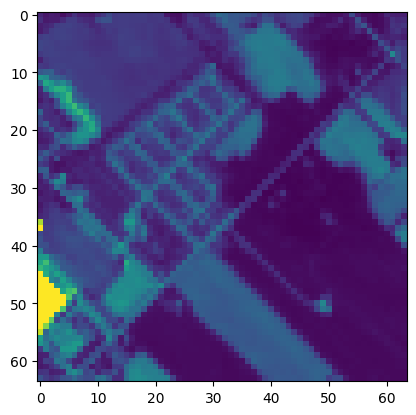

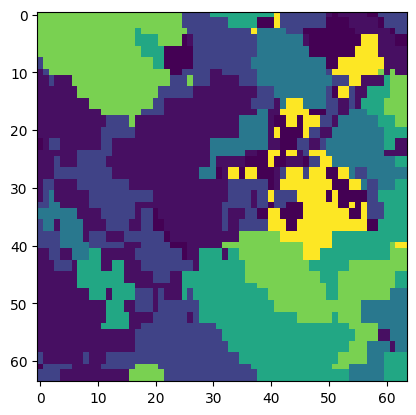

In [30]:
plt.figure(1)
plt.imshow(training_data[500, 1, :,:, 0])
plt.figure(2)
plt.imshow(train_mask[500, :,:])

### **Encoding Labels in Mask**

In [31]:
np.unique(test_mask), np.unique(train_mask), np.unique(valid_mask)

(array([  0,  10,  50, 100, 150, 200, 250], dtype=uint8),
 array([  0,  10,  50, 100, 150, 200, 250], dtype=uint8),
 array([  0,  10,  50, 100, 150, 200, 250], dtype=uint8))

In [32]:
class_mapping = {0: 0, 10: 1, 50: 2, 100: 3, 150: 4, 200: 5, 250: 6}

# Apply the mapping to convert pixel values to class labels
train_mask = np.vectorize(class_mapping.get)(train_mask)
valid_mask = np.vectorize(class_mapping.get)(valid_mask)
test_mask = np.vectorize(class_mapping.get)(test_mask)
np.unique(test_mask), np.unique(train_mask), np.unique(valid_mask)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([0, 1, 2, 3, 4, 5, 6]),
 array([0, 1, 2, 3, 4, 5, 6]))

# ***Training Model***

In [ ]:
expanded_train_mask = np.expand_dims(train_mask, axis=1)  # Adds a new dimension for samples

# Verify the shape of the expanded target data
print(expanded_train_mask.shape)

(782, 1, 64, 64)


In [ ]:
training_data.shape, train_mask.shape

((782, 6, 64, 64, 12), (782, 64, 64))

## ***3D-to-2D UNET***

In [55]:

def unet_model(input_shape, num_classes):
    # Encoder
    inputs = keras.Input(shape=input_shape)
    x = layers.TimeDistributed(layers.Conv2D(32, 3, padding="same", activation="relu"))(inputs)
    x = layers.TimeDistributed(layers.Conv2D(32, 3, padding="same", activation="relu"))(x)

    skip1 = layers.MaxPooling3D((6, 1, 1))(x)

    x = layers.TimeDistributed(layers.MaxPooling2D(2))(x)
    x = layers.TimeDistributed(layers.Conv2D(64, 3, padding="same", activation="relu"))(x)
    x = layers.TimeDistributed(layers.Conv2D(64, 3, padding="same", activation="relu"))(x)

    skip2 = layers.MaxPooling3D((6, 1, 1))(x)

    x = layers.TimeDistributed(layers.MaxPooling2D(2))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, 3, padding="same", activation="relu"))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, 3, padding="same", activation="relu"))(x)

    skip3 = layers.MaxPooling3D((6, 1, 1))(x)

    x = layers.TimeDistributed(layers.MaxPooling2D(2))(x)
    x = layers.TimeDistributed(layers.Conv2D(256, 3, padding="same", activation="relu"))(x)
    x = layers.TimeDistributed(layers.Conv2D(256, 3, padding="same", activation="relu"))(x)
    """
    skip4 = layers.MaxPooling3D((6, 1, 1))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D(2))(x)
    x = layers.TimeDistributed(layers.Conv2D(1024, 3, padding="same", activation="relu"))(x)
    x = layers.TimeDistributed(layers.Conv2D(1024, 3, padding="same", activation="relu"))(x)
    """
    # Add a MaxPooling3D layer without TimeDistributed wrapper
    x = layers.MaxPooling3D((6, 1, 1))(x)
    # Use tf.reshape to get rid of the time-stamp dimension
    x = tf.reshape(x, (-1, x.shape[2], x.shape[3], x.shape[4]))

    # Decoder
    """
    x = layers.Conv2DTranspose(512, 2, strides=2, padding="same", activation="relu")(x)
    x = layers.Concatenate()([x, tf.reshape(skip4, (-1, skip4.shape[2], skip4.shape[3], skip4.shape[4]))])
    x = layers.Conv2D(512, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(512, 3, padding="same", activation="relu")(x)
    """
    x = layers.Conv2DTranspose(256, 2, strides=2, padding="same", activation="relu")(x)
    x = layers.Concatenate()([x, tf.reshape(skip3, (-1, skip3.shape[2], skip3.shape[3], skip3.shape[4]))])
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    x = layers.Conv2DTranspose(128, 2, strides=2, padding="same", activation="relu")(x)
    x = layers.Concatenate()([x, tf.reshape(skip2, (-1, skip2.shape[2], skip2.shape[3], skip2.shape[4]))])
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

    x = layers.Conv2DTranspose(64, 2, strides=2, padding="same", activation="relu")(x)
    x = layers.Concatenate()([x, tf.reshape(skip1, (-1, skip1.shape[2], skip1.shape[3], skip1.shape[4]))])
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

    # Output layer
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(x)

    # Create and return the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (6, 64, 64, 12)
num_classes = 7
model = unet_model(input_shape, num_classes)
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 6, 64, 64, 12)]      0         []                            
                                                                                                  
 time_distributed_95 (TimeD  (None, 6, 64, 64, 32)        3488      ['input_8[0][0]']             
 istributed)                                                                                      
                                                                                                  
 time_distributed_96 (TimeD  (None, 6, 64, 64, 32)        9248      ['time_distributed_95[0][0]'] 
 istributed)                                                                                      
                                                                                            

In [ ]:
from tensorflow.keras.utils import to_categorical
categorical_train_mask = to_categorical(train_mask, num_classes=num_classes)
categorical_valid_mask = to_categorical(valid_mask, num_classes=num_classes)
categorical_test_mask = to_categorical(test_mask, num_classes=num_classes)



In [56]:
from tensorflow.keras.metrics import MeanIoU
iou_metric = MeanIoU(num_classes=num_classes)
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint_filepath = '/content/drive/MyDrive/Dl_Assignment/unet_project.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', iou_metric])


r = model.fit(training_data, categorical_train_mask, epochs=10, batch_size=2, validation_data=[valid_data, categorical_valid_mask], callbacks=[model_checkpoint])

Epoch 1/10
389/391 [============================>.] - ETA: 0s - loss: 1.9557 - accuracy: 0.3284 - mean_io_u_2: 0.4286
Epoch 1: val_accuracy improved from -inf to 0.36048, saving model to /content/drive/MyDrive/Dl_Assignment/unet_project.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


391/391 [==============================] - 14s 22ms/step - loss: 1.9538 - accuracy: 0.3282 - mean_io_u_2: 0.4286 - val_loss: 1.6596 - val_accuracy: 0.3605 - val_mean_io_u_2: 0.4286
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 1.4960 - accuracy: 0.4011 - mean_io_u_2: 0.4286
Epoch 2: val_accuracy improved from 0.36048 to 0.45789, saving model to /content/drive/MyDrive/Dl_Assignment/unet_project.h5
391/391 [==============================] - 6s 16ms/step - loss: 1.4960 - accuracy: 0.4011 - mean_io_u_2: 0.4286 - val_loss: 1.4852 - val_accuracy: 0.4579 - val_mean_io_u_2: 0.4286
Epoch 3/10
390/391 [============================>.] - ETA: 0s - loss: 1.4397 - accuracy: 0.4253 - mean_io_u_2: 0.4286
Epoch 3: val_accuracy improved from 0.45789 to 0.47620, saving model to /content/drive/MyDrive/Dl_Assignment/unet_project.h5
391/391 [==============================] - 8s 21ms/step - loss: 1.4394 - accuracy: 0.4254 - mean_io_u_2: 0.4286 - val_loss: 1.4761 - val_accuracy: 0.4762

# ***Model Evaluation***

In [58]:
model.evaluate(test_data,categorical_test_mask)

13/13 [==============================] - 1s 43ms/step - loss: 1.4539 - accuracy: 0.4089 - mean_io_u_2: 0.4286


[1.4538534879684448, 0.4089280664920807, 0.4285714328289032]

In [84]:
pred = model.predict(test_data)

13/13 [==============================] - 1s 40ms/step


In [92]:
pred1 = np.argmax(pred, 3)

In [93]:
pred1.shape

(391, 64, 64)

In [96]:
class_mapping2 = {0: 0, 1: 10, 2: 50, 3: 100, 4: 150, 5: 200, 6: 250}


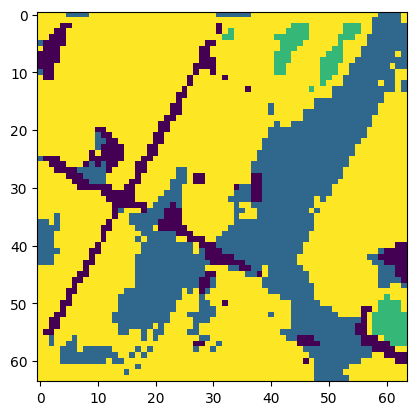

In [94]:
plt.imshow(pred1[1])

In [95]:
pred1[1]

array([[4, 4, 4, ..., 2, 2, 4],
       [4, 4, 4, ..., 2, 2, 4],
       [4, 4, 4, ..., 2, 2, 2],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]])

In [97]:
test_results = np.vectorize(class_mapping2.get)(pred1)

In [108]:
from patchify import unpatchify

In [109]:
#test_mask_path = '/content/aligned_mask/ground_2021.tif'
test_img = imread(test_mask_path)

In [111]:
test_img.shape

(1124, 1500)

In [132]:
filled_img = np.zeros(test_img.shape)
rows = 1124 // 64
cols = 1500 // 64

# Iterate over the patches and add them to the correct position in test_img
for i in range(rows):
    for j in range(cols):
        filled_img[i*64:(i+1)*64, j*64:(j+1)*64] = test_results[i*cols + j]

# If there are any remaining pixels in test_img, fill them with a suitable value (e.g., the average of all patches)
if rows * 64 < 1124 or cols * 64 < 1500:
    filled_img[rows*64:, :] = np.mean(test_results)
    filled_img[:, cols*64:] = np.mean(test_results)

print(filled_img.shape)

(1124, 1500)


## **Plotting Prediction**

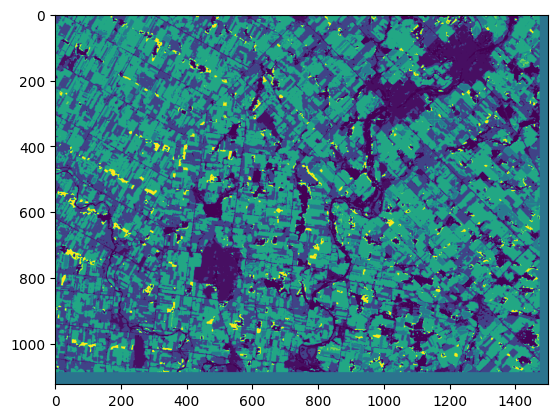

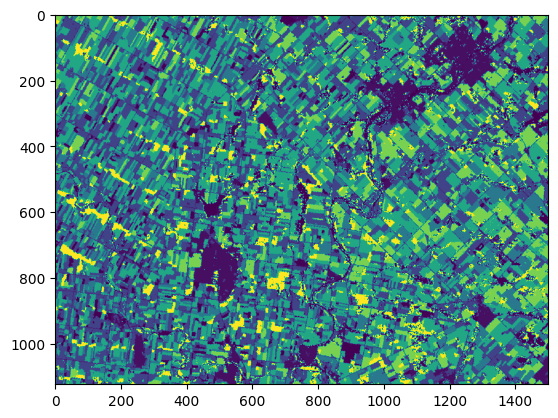

In [136]:
plt.figure(1)
plt.imshow(filled_img)

ground = imread('/content/aligned_mask/ground_2021.tif')
plt.figure(2)
plt.imshow(ground)

## **Saving Predicted Mask as Geotiff**

In [145]:
from rasterio.transform import from_origin
with rasterio.open('/content/ground_data/2021.tif') as src:
    transform = src.transform
    crs = src.crs
    profile = src.profile

# Create a new GeoTIFF file with the filled image and georeferencing information
output_path = '/content/drive/MyDrive/Dl_Assignment/2021_pred_proj.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(filled_img, 1)

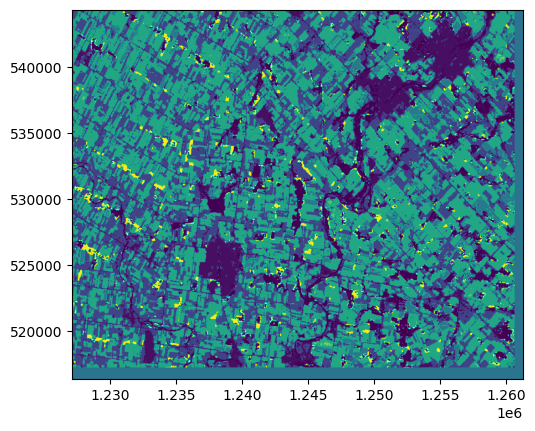

<Axes: >

In [146]:
pred_mask = rasterio.open(output_path)
show(pred_mask)